# Data generation
This notebook shows the capabilities of our decoder. Several signals are generated according to 4 different models for an input X constant, X random and X sinusoidal with additional noise.

## Librairies importation

In [1]:
print(f"Importing librairies ... ", end='')
import sys
sys.path.append(r"C:\Users\valentin\Documents\HMM")
import numpy as np
from myHmmPackage.cluster_decoder import ClusterDecoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
print('done')

Importing librairies ... done


## Hyperparameters

In [2]:
### data ###
n_samples = 100 #n_trials
n_time_points = 102
n_regions = 2 #IC ou region ou electrod ou channels
n_label_features = 48 
n_clusters = 4 # n_clusters

## Data generation

In [122]:
def get_sinusoidal_X() :
    a_list = np.random.uniform(low=0,high=2*np.pi/n_time_points, size=(n_clusters,n_regions))
    omega_list = np.random.uniform(low=0,high=2*np.pi/n_time_points, size=(n_clusters,n_regions))
    sigma = np.random.uniform(low=0.001,high=0.1,size=n_samples)

    def a(t,r):
        idx = np.count_nonzero(transition <= t) - 1
        return a_list[idx,r]

    def omega(t,r):
        idx = np.count_nonzero(transition <= t) - 1
        return omega_list[idx,r]

    def f(s,t,r):
        return a(t,r)*np.cos(omega(t,r)*t) + sigma[s]*np.random.normal(loc=0, scale=sigma[s])


    return np.array([[[f(s,t,r) for r in range(n_regions)]
                            for t in range(n_time_points)]
                            for s in range(n_samples)],
                    dtype=float)

def get_random_X():
    return np.random.uniform(low=-10, high=10, size=(n_samples, n_time_points, n_regions))

def get_constant_X():
    return np.random.uniform(low=-10, high=10)*np.ones(shape=(n_samples, n_time_points, n_regions))

def get_mix_models(gamma,W):
    gamma = np.transpose(gamma,(1,0))
    W_temp = np.reshape(W, newshape=(n_regions, n_clusters, n_label_features))
    return np.sum(gamma @ W_temp, axis=1)
     
def get_y(X, W):
    y = X @ W
    y = np.reshape(y, newshape=(n_samples, n_time_points, n_label_features))
    return y

In [140]:
transition = np.random.randint(n_time_points,size=(n_clusters-1))
transition = np.concatenate(([0],np.sort(transition),[n_time_points]))

data_type = 'sinusoidal' # valid input : constant, random, sinusoidal

if data_type == 'constant' :
    X = get_constant_X()
elif data_type == 'random' :
    X = get_random_X()
elif data_type == 'sinusoidal' :
    X = get_sinusoidal_X()
else : raise ValueError(f"Input received : '{data_type}. Valid input : 'constant', 'random', 'sinusoidal''")
    
W = np.random.randint(low=-10, high=10,size=(n_clusters, n_regions, n_label_features))

gamma = np.array([[1 if (transition[(j)] <= i) and (i < transition[(j+1)]) else 0 for i in range(n_time_points)] 
                for j in range(n_clusters)],dtype=int)
W_mix = get_mix_models(gamma, W)
y = get_y(X, W_mix)

## Plot

### Inputs X for a given region id_r

(100, 102, 2)


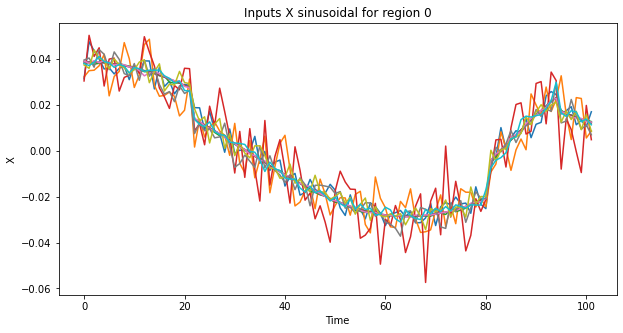

In [141]:
id_r = 0
print(np.shape(X))
plt.figure(figsize=(10,5))
for id_s in range(10):
    plt.plot(range(n_time_points), X[id_s,:,id_r])
plt.xlabel('Time')
plt.ylabel('X')
plt.title(f"Inputs X {data_type} for region {id_r}")
plt.show()

### Gamma

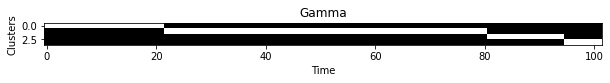

In [142]:
plt.figure(figsize=(10,5))
plt.imshow(gamma,cmap='gray')
plt.xlabel("Time")
plt.ylabel("Clusters")
plt.title(f"Gamma")
plt.show()

### Models W

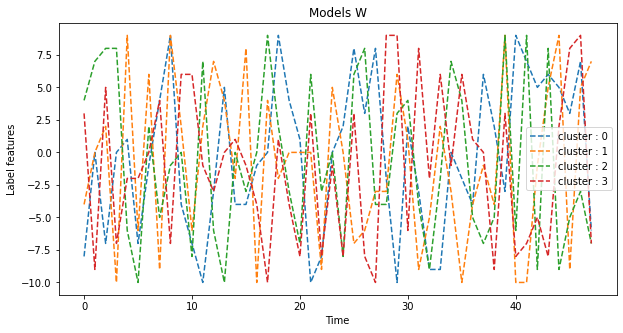

In [143]:
plt.figure(figsize=(10,5))
k = np.random.randint(n_regions)
for id_cluster in range(n_clusters):
    plt.plot(W[id_cluster,k,:].T, '--', label=f"cluster : {id_cluster}" )
plt.legend()
plt.xlabel("Time")
plt.ylabel("Label features")
plt.title("Models W")
plt.show()

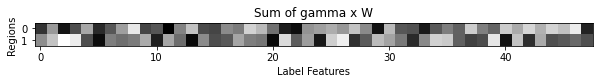

In [144]:
plt.figure(figsize=(10,5))
plt.imshow(W_mix,cmap='gray')
plt.xlabel("Label Features")
plt.ylabel("Regions")
plt.title("Sum of gamma x W")
plt.show()

## Training

In [145]:
print(f"Starting cluster decoder ... ")
clf = ClusterDecoder(n_clusters=n_clusters, method='sequential', max_iter=1e3)
clf.fit(X,y) # renvoie gamma et W
print('done\n')


Starting cluster decoder ... 


100%|██████████| 999/999 [00:12<00:00, 81.79it/s]

done



## Results

### Gamma

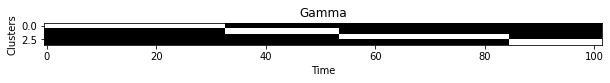

In [146]:
plt.figure(figsize=(10,5))
plt.imshow(clf.gamma_.T,cmap='gray')
plt.xlabel("Time")
plt.ylabel("Clusters")
plt.title(f"Gamma")
plt.show()

### Models W

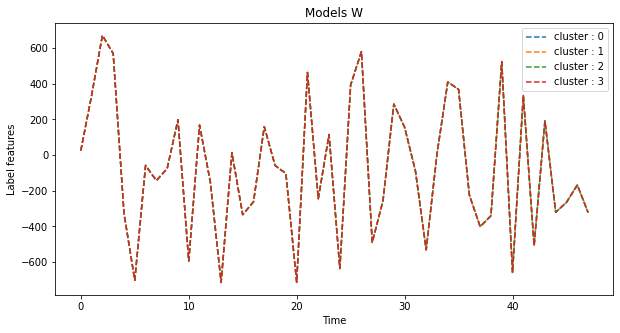

In [147]:
plt.figure(figsize=(10,5))
k = np.random.randint(n_regions)
for id_cluster in range(n_clusters):
    plt.plot(clf.decoding_mats_[id_cluster,k,:].T, '--', label=f"cluster : {id_cluster}" )
plt.legend()
plt.xlabel("Time")
plt.ylabel("Label features")
plt.title("Models W")
plt.show()

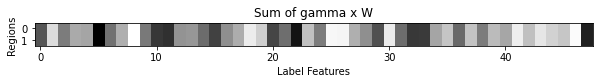

In [148]:
plt.figure(figsize=(10,5))
plt.imshow(get_mix_models(clf.gamma_.T, clf.decoding_mats_),cmap='gray')
plt.xlabel("Label Features")
plt.ylabel("Regions")
plt.title("Sum of gamma x W")
plt.show()

## Test

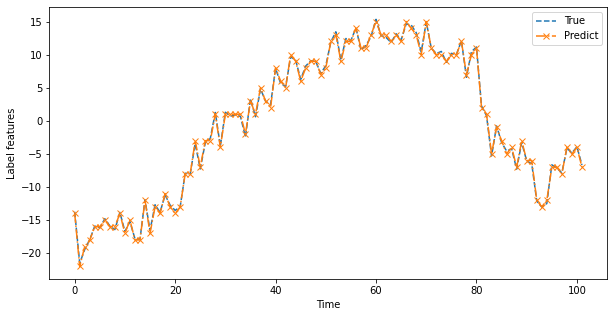

In [149]:
id_sample = 0
id_feat = 0
plt.figure(figsize=(10,5))
plt.plot(y[id_sample,:,id_feat].T, '--', label="True")
plt.plot(clf.predict(X)[id_sample,:,id_feat].T, '-.x', label="Predict")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Label features")
plt.show()

In [150]:
y_true = y.flatten()
y_predict = clf.predict(X).flatten()
print(f"r2_score : {r2_score(y_true, y_predict)}")
print(f"mean_squared_error : {mean_squared_error(y_true, y_predict)}")    
print(f"mean_absolute_percentage_error : {mean_absolute_percentage_error(y_true, y_predict)}")

r2_score : 0.9995801897393919
mean_squared_error : 0.08332917169486406
mean_absolute_percentage_error : 0.0729985646090408
